In [1]:

import numpy as np
import scipy as sp
import h5py
import os

import SimData as sim_data
import Simulator as sim_system
import Uncertainty as unc
import Optimization as opt

In [2]:

###* Input files and function

reactions_file = "reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                      'Odb_S': 0.1, 'CO_F': 0.0, 'CO2_F':0.0, 'CO_S': 0.0, 
                      'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15 if exp_dict['Tw'] < 100 else exp_dict['Tw'], #! avoid double counting -> convert from celsius to kelvin
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}


output_folder_path = "Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"

In [3]:

exp_file = os.path.join(output_folder_path, exp_data_file)
sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


# print(sim.output_parser['rates_model'])
# print(sim.output_parser['reactions_list'])
# print(sim.exp_data_arr[0].keys())


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [4]:

if __name__ == '__main__':
    
    
    loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)
    
    def func_new_dict(params):
    
        A, B, E = params
        nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
        
        dict_mod_vec = [
        {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 31, "rate": None, "model_dict": {"nu_d": nu_d_mod}}
        ]
        
        return dict_mod_vec
    
    
    based_model_parameters = [2.777e-02,  7.792e-04, 1.627e+01]
    
    #### truncated gaussian distribution 
    error_prop = unc.ErrorPropagator(sim, func_new_model_dict=func_new_dict, model_param_list=based_model_parameters,\
                                    transformations_exp=transformations_exp)
    
    optimizer = opt.Optimizer(sim, func_new_dict, loss_function)
    
    # model_uncert_list = [(0.0, 1.0, 0.0, np.inf),
    #                      [1e13, 0.1*1e13, 0.0, np.inf]]  


In [5]:

exp_uncert_list = [('CO', 0.1, 0.0, np.inf),
                   ('CO2', 0.1, 0.0, np.inf), 
                   ('O', 0.1, 0.0, np.inf), 
                   ('O2', 0.1, 0.0, np.inf), 
                    ('Tw', 0.01, 0.0, np.inf),
                    ('Tgas', 0.01, 0.0, np.inf),
                ]

    
samples_uncert_param, gammas_uncert_array = error_prop.propagate_experimental_condition_uncertainty(exp_uncert_list, num_samples_N=1200, num_workers=8)



100%|██████████| 1200/1200 [04:53<00:00,  4.09it/s]


In [6]:

gammas_uncert_mean_arr = gammas_uncert_array.mean(axis=0)
gammas_uncert_std_arr = gammas_uncert_array.std(axis=0)



In [10]:
print(gammas_uncert_array.shape)

(1200, 94)


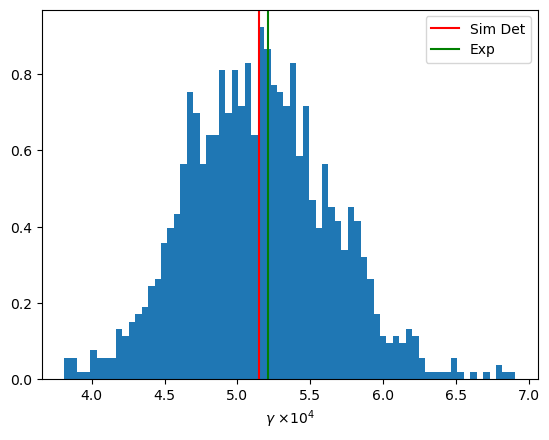

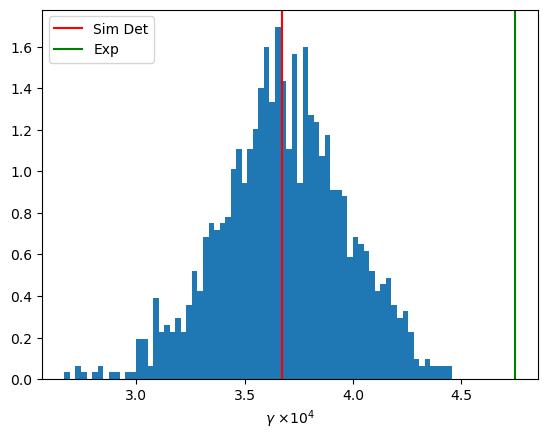

In [36]:

counter= 35
plt.figure()
plt.hist(gammas_uncert_array[:, counter]*1e4, bins=70, density=True)
plt.axvline(x=gamma_sum_arr[counter]*1e4, color="red", label="Sim Det")
plt.axvline(x=gamma_exp_data[counter]*1e4, color="green", label="Exp")
plt.legend()
plt.xlabel(r"$\gamma$ $\times 10^{4}$")
plt.savefig("figures/hist1.png")



counter= 36
plt.figure()
plt.hist(gammas_uncert_array[:, counter]*1e4, bins=70, density=True)
plt.axvline(x=gamma_sum_arr[counter]*1e4, color="red", label="Sim Det")
plt.axvline(x=gamma_exp_data[counter]*1e4, color="green", label="Exp")
plt.legend()
plt.xlabel(r"$\gamma$ $\times 10^{4}$")
plt.savefig("figures/hist2.png")


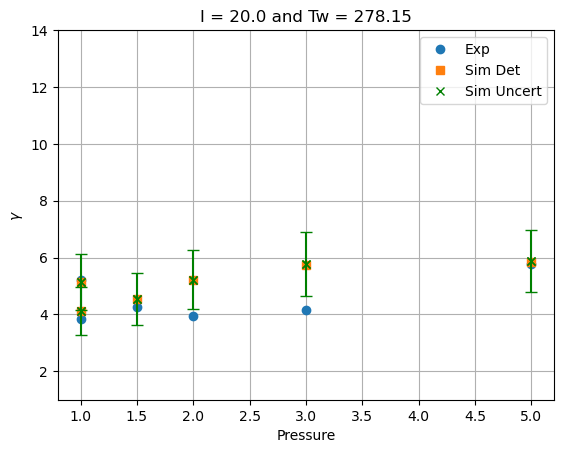

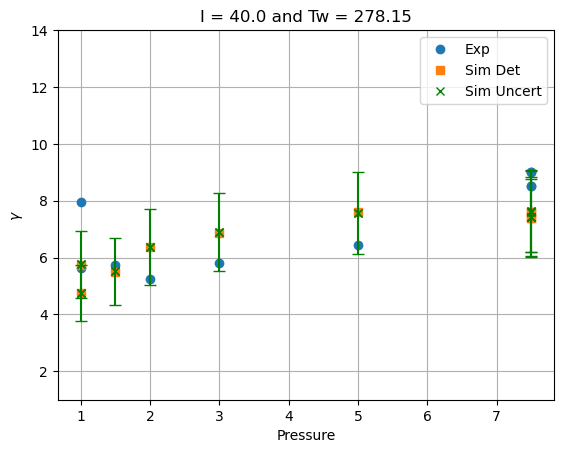

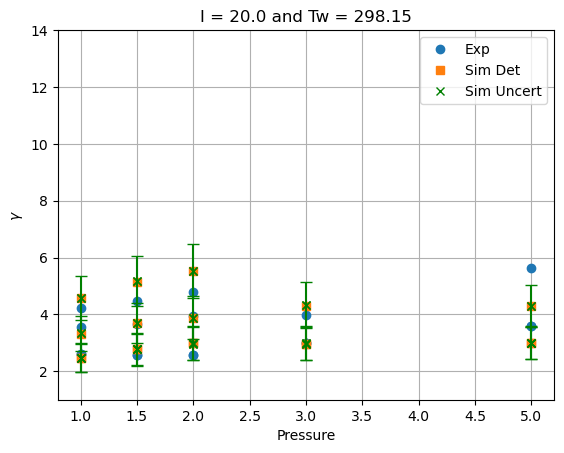

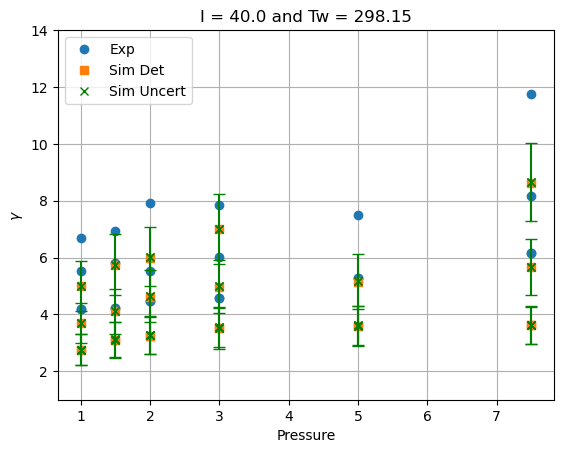

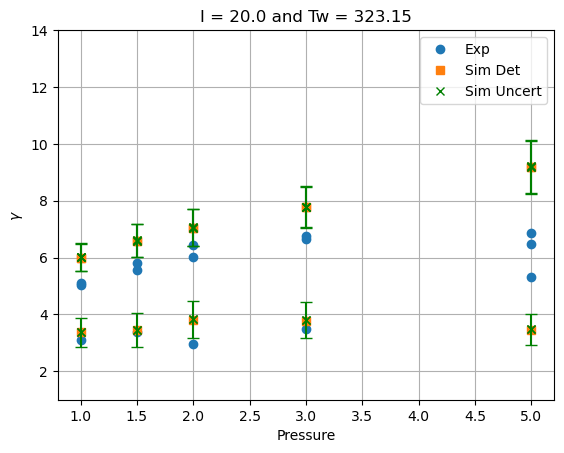

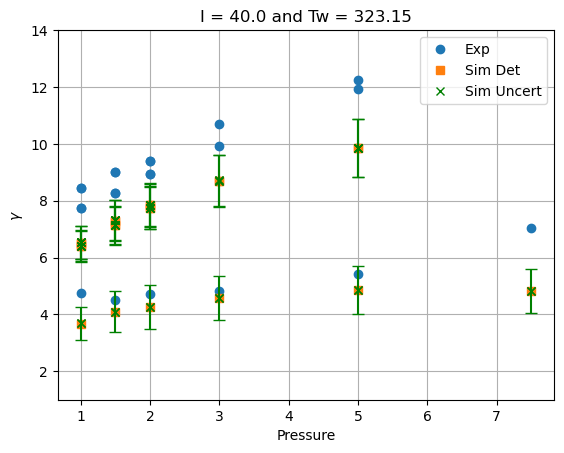

In [8]:



_, _, gamma_sum_arr, gamma_exp_data = optimizer.solve_simulations_updated(based_model_parameters)




import matplotlib.pyplot as plt

label_sim = "Sim Det"
label_uncert = "Sim Uncert"

### plots

exp_data_arr = optimizer.exp_data_arr

inv_Tnw_vec = np.array([300/vec['Tnw'] for vec in exp_data_arr])

current_vec = np.array([vec['current'] for vec in exp_data_arr])
Tw_vec = np.array([vec['Tw'] for vec in exp_data_arr])

current_unique = np.unique(current_vec)
Tw_unique = np.unique([vec['Tw'] for vec in exp_data_arr])


A, B = np.meshgrid(current_unique, Tw_unique)
combinations = np.stack([A.ravel(), B.ravel()], axis=1)

for comb in combinations:
    current = comb[0]
    Tw = comb[1]

    idx_valid = np.logical_and(current_vec == current, Tw_vec == Tw)
    data_arr = exp_data_arr[idx_valid]
    
    pressure_vec = np.array([vec['pressure'] for vec in data_arr])
    gamma_exp = gamma_exp_data[idx_valid]
    gamma_sim_base = gamma_sum_arr[idx_valid]
    gamma_sim_uncert = gammas_uncert_mean_arr[idx_valid]
    gamma_sim_std_uncert = gammas_uncert_std_arr[idx_valid]
        
    plt.figure()
    plt.plot(pressure_vec, gamma_exp*1e4, 'o', label="Exp")
    plt.plot(pressure_vec, gamma_sim_base*1e4, 's', label=label_sim)
    plt.plot(pressure_vec, gamma_sim_uncert*1e4, 'x', label=label_uncert, color="green")
    
    
    yerr = 2 * gamma_sim_std_uncert * 1e4  # Error is ±2*std

    plt.errorbar(
        pressure_vec, gamma_sim_uncert*1e4,
        yerr=yerr,
        fmt='x',         # 'x' marker for the point
        capsize=4,       # Length of the error bar cap
        color="green"
    )
    
    
    plt.title(f"I = {current} and Tw = {Tw}")
    plt.xlabel("Pressure")
    plt.ylabel(r"$\gamma$")
    plt.legend()
    plt.grid()
    plt.ylim(1, 14)
    # plt.show()
    plt.savefig(f"figures/uncert_{current}_{Tw}.png")
